In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import glob
import pandas as pd
import numpy as np
from sglm.helpers import filehelpers as fh, dfhelpers as dfh
from pathlib import Path

In [4]:
base_location = Path(r'/Users/Josh/Documents/GitHub/sabatinilab-glm/sglm/outputs')


load_folder = base_location / Path(r'Figure_1_2')
h5_beta_locations = str((load_folder / Path(r'all/hypswp-50-wds*-ft/coefs/*_best_coeffs.h5')).resolve())

# load_folder = base_location / Path(r'Figure_1_2')
# h5_beta_locations = str((load_folder / Path(r'all\f1*-ft\coefs\*_best_coeffs.h5')).resolve())
# load_folder = base_location / Path(r'Figure_3')
# h5_beta_locations = str((load_folder / Path(r'all\f3*-ft\coefs\*_best_coeffs.h5')).resolve())
# load_folder = base_location / Path(r'Figure_4_g1')
# h5_beta_locations = str((load_folder / Path(r'all\f4*-ft\coefs\*_best_coeffs.h5')).resolve())
# load_folder = base_location / Path(r'Figure_4_g2')
# h5_beta_locations = str((load_folder / Path(r'all\f4*-ft\coefs\*_best_coeffs.h5')).resolve())
# load_folder = base_location / Path(r'Figure_5_g1')
# h5_beta_locations = str((load_folder / Path(r'all\f5*-ft\coefs\*_best_coeffs.h5')).resolve())
# load_folder = base_location / Path(r'Figure_5_g2')
# h5_beta_locations = str((load_folder / Path(r'all\f5*-ft\coefs\*_best_coeffs.h5')).resolve())
# load_folder = base_location / Path(r'Figure_5_g5')
# h5_beta_locations = str((load_folder / Path(r'all\f5*-ft\coefs\*_best_coeffs.h5')).resolve())

out_folder = base_location / Path(r'final_outputs_rev_hps-wds')

# h5_beta_locations = Path('/Users/josh/Dropbox (HMS)/jz/Tetanus/1194_1195_1214_1258_1259_2_best_coeffs.h5')
out_loc = str((out_folder).resolve())
h5_beta_locations = glob.glob(h5_beta_locations)

In [5]:
h5_lst = []
for h5_coef_fn in h5_beta_locations:
    h5f = pd.HDFStore(h5_coef_fn)
    h5fk = h5f.keys()
    for key in h5fk:
        h5_df = pd.read_hdf(h5f, key).reset_index()
        h5_df['fn'] = h5_coef_fn
        h5_df['key'] = key
        h5_df = h5_df.set_index(['fn','key'])
        
        
        h5_df = h5_df.sort_values('channel_name')
        h5_df['channel'] = h5_df['channel_name'].str.split('_').apply(lambda x: x[0])
        h5_df['run_num'] = h5_df['channel_name'].str.split('_').apply(lambda x: x[-1])
        
        h5_df['model_version'] = '_'.join(key.split('_')[3:]).split('_run_num')[0]
        
        h5_lst.append(h5_df)
concat = pd.concat(h5_lst, axis=0)

In [6]:
concat

level_0  \
fn                                                 key                                                                                                  
C:\Users\Josh\Documents\GitHub\sabatinilab-glm\... /gACH_0_0_base_words_max_iter10000__fit_interce...  63_64_65_66_67_68_69_57_58_59_60_61_53_55_56_0   
                                                   /gACH_0_0_base_words_max_iter10000__fit_interce...  63_64_65_66_67_68_69_57_58_59_60_61_53_55_56_0   
                                                   /gACH_0_0_base_words_max_iter10000__fit_interce...  63_64_65_66_67_68_69_57_58_59_60_61_53_55_56_0   
C:\Users\Josh\Documents\GitHub\sabatinilab-glm\... /gACH_0_0_base_words_max_iter10000__fit_interce...  63_64_65_66_67_68_69_57_58_59_60_61_53_55_56_0   
                                                   /gACH_0_0_base_words_max_iter10000__fit_interce...  63_64_65_66_67_68_69_57_58_59_60_61_53_55_56_0   
...                                                                                                                                               ...   
C:\Users\Josh\Documents\GitHub\sabatinilab-glm\... /gDA_2_0_base_words_max_iter10000__fit_intercep...  63_64_65_66_67_68_69_57_58_59_60_61_53_55_56_2   
                                                   /gDA_2_0_base_words_max_iter10000__fit_intercep...  63_64_65_66_67_68_69_57_58_59_60_61_53_55_56_2   
C:\Users\Josh\Documents\GitHub\sabatinilab-glm\... /gDA_2_0_base_words_max_iter10000__fit_intercep...  63_64_65_66_67_68_69_57_58_59_60_61_53_55_56_2   
                                                   /gDA_2_0_base_words_max_iter10000__fit_intercep...  63_64_65_66_67_68_69_57_58_59_60_61_53_55_56_2   
                                                   /gDA_2_0_base_words_max_iter10000__fit_intercep...  63_64_65_66_67_68_69_57_58_59_60_61_53_55_56_2   

                                                                                                                                           mouse_id  \
fn                                                 key                                                                                                
C:\Users\Josh\Documents\GitHub\sabatinilab-glm\... /gACH_0_0_base_words_max_iter10000__fit_interce...  63_64_65_66_67_68_69_57_58_59_60_61_53_55_56   
                                                   /gACH_0_0_base_words_max_iter10000__fit_interce...  63_64_65_66_67_68_69_57_58_59_60_61_53_55_56   
                                                   /gACH_0_0_base_words_max_iter10000__fit_interce...  63_64_65_66_67_68_69_57_58_59_60_61_53_55_56   
C:\Users\Josh\Documents\GitHub\sabatinilab-glm\... /gACH_0_0_base_words_max_iter10000__fit_interce...  63_64_65_66_67_68_69_57_58_59_60_61_53_55_56   
                                                   /gACH_0_0_base_words_max_iter10000__fit_interce...  63_64_65_66_67_68_69_57_58_59_60_61_53_55_56   
...                                                                                                                                             ...   
C:\Users\Josh\Documents\GitHub\sabatinilab-glm\... /gDA_2_0_base_words_max_iter10000__fit_intercep...  63_64_65_66_67_68_69_57_58_59_60_61_53_55_56   
                                                   /gDA_2_0_base_words_max_iter10000__fit_intercep...  63_64_65_66_67_68_69_57_58_59_60_61_53_55_56   
C:\Users\Josh\Documents\GitHub\sabatinilab-glm\... /gDA_2_0_base_words_max_iter10000__fit_intercep...  63_64_65_66_67_68_69_57_58_59_60_61_53_55_56   
                                                   /gDA_2_0_base_words_max_iter10000__fit_intercep...  63_64_65_66_67_68_69_57_58_59_60_61_53_55_56   
                                                   /gDA_2_0_base_words_max_iter10000__fit_intercep...  63_64_65_66_67_68_69_57_58_59_60_61_53_55_56   

                                                                                                           channel_name  \
fn                                                 key           

In [7]:
fh.create_folder_if_not_exists(out_loc)

Created directory: C:\Users\Josh\Documents\GitHub\sabatinilab-glm\sglm\outputs\final_outputs_rev_hps-wds


In [8]:
base_keys = list({
                # 'gACH':(0,0),
                # 'rDA':(0,0),
                # 'gDA':(0,0),
                'photometryCenterInIndex':(0,0),
                'photometryCenterOutIndex':(0,0),
                'photometrySideInIndex':(0,0),
                'photometrySideInIndexr':(0,0),
                'photometrySideOutIndex':(0,0),
                'sl': (0,0),
                'spnnrOff': (0,0),
                'photometryCenterInIndex':(0,0),
                'photometryCenterOutIndex':(0,0),
                'photometrySideInIndexAA':(0,0),
                'photometrySideInIndexAa':(0,0),
                'photometrySideInIndexaA':(0,0),
                'photometrySideInIndexaa':(0,0),
                'photometrySideInIndexAB':(0,0),
                'photometrySideInIndexAb':(0,0),
                'photometrySideInIndexaB':(0,0),
                'photometrySideInIndexab':(0,0),
                'photometrySideOutIndex':(0,0),
                'sl': (0,0),
                'spnnrOff': (0,0),
                }.keys())
# base_keys

In [9]:
save_mse_scatter = concat.reset_index().set_index(['mouse_id', 'channel', 'name', 'model_version', 'run_num'])[['mse_tr', 'mse_cv', 'mse_te']]
save_mse_scatter.to_csv(str((Path(out_loc) / f'{load_folder.parts[-1]}-mse_sctr.csv').resolve()))

save_r2_scatter = concat.reset_index().set_index(['mouse_id', 'channel', 'name', 'model_version', 'run_num'])[['r2_tr', 'r2_cv', 'r2_te']]
save_r2_scatter.to_csv(str((Path(out_loc) / f'{load_folder.parts[-1]}-r2_sctr.csv').resolve()))

In [10]:
agg = concat.drop(['channel_name', 'timestamp', 'run_num'], axis=1).groupby(['channel', 'name']).agg([np.size, np.mean, np.std])
stk = agg[['mse_tr', 'mse_cv', 'mse_te']].rename({'mse_tr':'01_mse_tr', 'mse_cv':'02_mse_cv', 'mse_te':'03_mse_te'}, axis=1).swaplevel(axis=1).stack()

stk['lb'] = stk['mean'] - 1.96*stk['std']/np.sqrt(stk['size'])
stk['mn'] = stk['mean']
stk['ub'] = stk['mean'] + 1.96*stk['std']/np.sqrt(stk['size'])

plt_df = stk[['lb', 'mn', 'ub']].unstack().swaplevel(axis=1)

gACH = plt_df.loc['gACH'] if 'gACH' in plt_df.reset_index()['channel'].unique() else plt_df.iloc[0:0]
rDA = plt_df.loc['rDA'] if 'rDA' in plt_df.reset_index()['channel'].unique() else plt_df.iloc[0:0]
gDA = plt_df.loc['gDA'] if 'gDA' in plt_df.reset_index()['channel'].unique() else plt_df.iloc[0:0]

save_ci = stk[['mean', 'size', 'std']].unstack().swaplevel(axis=1).sort_index(axis=1)
save_ci.to_csv(str((Path(out_loc) / f'{load_folder.parts[-1]}-mse_ci.csv').resolve()))

C:\Users\Josh\AppData\Local\Temp\ipykernel_14484\2044627354.py:1: FutureWarning: ['model_version'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  agg = concat.drop(['channel_name', 'timestamp', 'run_num'], axis=1).groupby(['channel', 'name']).agg([np.size, np.mean, np.std])


In [11]:
stk

mean  size       std        lb        mn  \
channel name                                                                 
gACH    base_words 01_mse_tr  0.859211    48  0.091171  0.833419  0.859211   
                   02_mse_cv  0.860242    48  0.090831  0.834546  0.860242   
                   03_mse_te  0.861779    48  0.091772  0.835817  0.861779   
gDA     base_words 01_mse_tr  0.855288    48  0.089685  0.829916  0.855288   
                   02_mse_cv  0.856839    48  0.088899  0.831689  0.856839   
                   03_mse_te  0.854740    48  0.087910  0.829871  0.854740   
rDA     base_words 01_mse_tr  0.864332    48  0.075185  0.843062  0.864332   
                   02_mse_cv  0.866223    48  0.074739  0.845079  0.866223   
                   03_mse_te  0.865489    48  0.071628  0.845226  0.865489   

                                    ub  
channel name                            
gACH    base_words 01_mse_tr  0.885004  
                   02_mse_cv  0.885938  
                   03_mse_te  0.887741  
gDA     base_words 01_mse_tr  0.880660  
                   02_mse_cv  0.881989  
                   03_mse_te  0.879610  
rDA     base_words 01_mse_tr  0.885602  
                   02_mse_cv  0.887366  
                   03_mse_te  0.885753

In [12]:
import matplotlib.pyplot as plt

['']


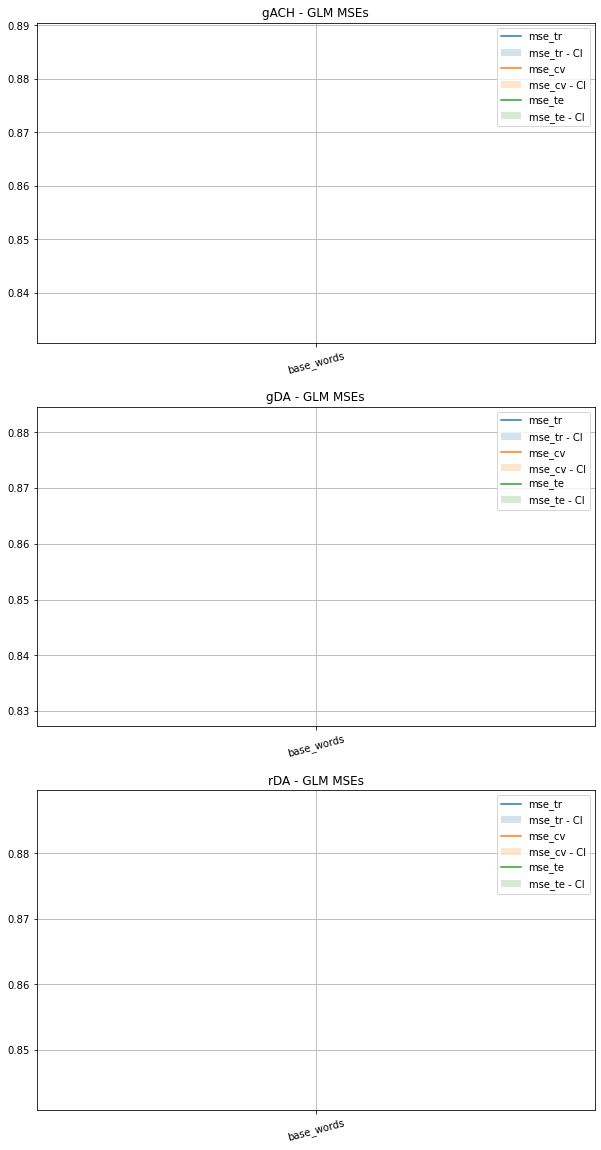

In [13]:
rot = 15

fig,axes=plt.subplots(3,1,figsize=(10,20))
fig.set_facecolor('w')

if len(gACH) > 0:
    ax = axes[0]
    ax.plot(gACH.index, gACH['01_mse_tr']['mn'], label='mse_tr')
    ax.fill_between(gACH.index, gACH['01_mse_tr']['lb'], gACH['01_mse_tr']['ub'], alpha=0.2, label='mse_tr - CI')
    ax.plot(gACH.index, gACH['02_mse_cv']['mn'], label='mse_cv')
    ax.fill_between(gACH.index, gACH['02_mse_cv']['lb'], gACH['02_mse_cv']['ub'], alpha=0.2, label='mse_cv - CI')
    ax.plot(gACH.index, gACH['03_mse_te']['mn'], label='mse_te')
    ax.fill_between(gACH.index, gACH['03_mse_te']['lb'], gACH['03_mse_te']['ub'], alpha=0.2, label='mse_te - CI')
    print([_.get_text() for _ in ax.xaxis.get_ticklabels()])
    ax.set_title('gACH - GLM MSEs')
    ax.legend()
    ax.grid(True)
    for tick in ax.get_xticklabels():
        tick.set_rotation(rot)

if len(gDA) > 0:
    ax = axes[1]
    ax.plot(gDA.index, gDA['01_mse_tr']['mn'], label='mse_tr')
    ax.fill_between(gDA.index, gDA['01_mse_tr']['lb'], gDA['01_mse_tr']['ub'], alpha=0.2, label='mse_tr - CI')
    ax.plot(gDA.index, gDA['02_mse_cv']['mn'], label='mse_cv')
    ax.fill_between(gDA.index, gDA['02_mse_cv']['lb'], gDA['02_mse_cv']['ub'], alpha=0.2, label='mse_cv - CI')
    ax.plot(gDA.index, gDA['03_mse_te']['mn'], label='mse_te')
    ax.fill_between(gDA.index, gDA['03_mse_te']['lb'], gDA['03_mse_te']['ub'], alpha=0.2, label='mse_te - CI')
    ax.set_title('gDA - GLM MSEs')
    ax.legend()
    ax.grid(True)
    for tick in ax.get_xticklabels():
        tick.set_rotation(rot)

if len(rDA) > 0:
    ax = axes[2]
    ax.plot(rDA.index, rDA['01_mse_tr']['mn'], label='mse_tr')
    ax.fill_between(rDA.index, rDA['01_mse_tr']['lb'], rDA['01_mse_tr']['ub'], alpha=0.2, label='mse_tr - CI')
    ax.plot(rDA.index, rDA['02_mse_cv']['mn'], label='mse_cv')
    ax.fill_between(rDA.index, rDA['02_mse_cv']['lb'], rDA['02_mse_cv']['ub'], alpha=0.2, label='mse_cv - CI')
    ax.plot(rDA.index, rDA['03_mse_te']['mn'], label='mse_te')
    ax.fill_between(rDA.index, rDA['03_mse_te']['lb'], rDA['03_mse_te']['ub'], alpha=0.2, label='mse_te - CI')
    ax.set_title('rDA - GLM MSEs')
    ax.legend()
    ax.grid(True)

    for tick in ax.get_xticklabels():
        tick.set_rotation(rot)

plt.show()
